# Intent and Slot Filling with Curriculum Learning

This notebook demonstrates implementing a joint intent classification and slot filling model for natural language understanding (NLU) using curriculum learning.

## What is Curriculum Learning?

Curriculum learning is a training strategy inspired by the way humans learn, where models are trained on examples of gradually increasing difficulty. The key ideas are:

1. **Start Simple**: Begin with easier examples that have clear patterns
2. **Progressive Difficulty**: Gradually introduce more complex examples
3. **Competence-Based Progression**: Advance to harder examples once the model masters simpler ones

## Benefits of Curriculum Learning

- **Faster Convergence**: Often leads to faster training, especially in the early stages
- **Better Generalization**: Can help models generalize better by building foundational knowledge first
- **Avoiding Local Minima**: May help avoid poor local minima by guiding optimization

## Implementation Approaches

In this notebook, we implement curriculum learning for joint intent and slot prediction in several ways:

1. **Static Curriculum**: Pre-define difficulty based on features like sentence length, number of slots, etc.
2. **Competence-Based Curriculum**: Dynamically adjust the curriculum based on model performance
3. **Alternative Difficulty Metrics**: Explore different ways to measure example difficulty

We compare these approaches with standard training to demonstrate the benefits of curriculum learning.

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertModel
from collections import defaultdict
import json
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize

# --------- 1. Expanded Training Data ---------
# Load data from Sample_user_queries.csv
csv_data = pd.read_csv('Sample_user_queries.csv')

# Manual data - Your prompts split into words with slot labels and intent
manual_data = [
    # add_expense
    {"words": ["Add", "expense", "of", "$20", "to", "group", "Travel", "Friends"],
     "slots": ["O", "O", "O", "B-amount", "O", "O", "B-group", "I-group"], "intent": "add_expense"},
    {"words": ["Add", "rent", "of", "$1200", "to", "House", "Bills", "group"],
     "slots": ["O", "O", "O", "B-amount", "O", "B-group", "I-group", "O"], "intent": "add_expense"},
    {"words": ["Add", "$95", "groceries", "to", "House", "Bills", "group"],
     "slots": ["O", "B-amount", "O", "O", "B-group", "I-group", "O"], "intent": "add_expense"},
    {"words": ["Add", "a", "$350", "software", "charge", "to", "Startup", "Budget", "group"],
     "slots": ["O", "O", "B-amount", "O", "O", "O", "B-group", "I-group", "O"], "intent": "add_expense"},
    {"words": ["Log", "$60", "Spotify", "family", "plan", "to", "Monthly", "Subscriptions"],
     "slots": ["O", "B-amount", "B-service", "I-service", "I-service", "O", "B-group", "I-group"], "intent": "add_expense"},
    {"words": ["Add", "equipment", "bill", "of", "$480", "to", "Band", "Practice", "group"],
     "slots": ["O", "O", "O", "O", "B-amount", "O", "B-group", "I-group", "O"], "intent": "add_expense"},
    {"words": ["Add", "a", "dinner", "bill", "of", "$240", "to", "Tahoe", "trip", "group"],
     "slots": ["O", "O", "O", "O", "O", "B-amount", "O", "B-group", "I-group", "O"], "intent": "add_expense"},
    {"words": ["Record", "a", "payment", "of", "$75", "for", "internet", "to", "Utilities", "group"],
     "slots": ["O", "O", "O", "O", "B-amount", "O", "B-service", "O", "B-group", "O"], "intent": "add_expense"},
    {"words": ["Add", "$122.50", "restaurant", "bill", "to", "Weekend", "Fun", "group"],
     "slots": ["O", "B-amount", "O", "O", "O", "B-group", "I-group", "O"], "intent": "add_expense"},
    {"words": ["Log", "movie", "tickets", "expense", "of", "$42", "to", "Entertainment", "group"],
     "slots": ["O", "B-service", "I-service", "O", "O", "B-amount", "O", "B-group", "O"], "intent": "add_expense"},
    {"words": ["Add", "my", "share", "of", "$220", "for", "the", "concert", "to", "Music", "Expenses"],
     "slots": ["O", "O", "O", "O", "B-amount", "O", "O", "B-service", "O", "B-group", "I-group"], "intent": "add_expense"},
    {"words": ["Record", "$18.75", "for", "coffee", "in", "Office", "Supplies", "group"],
     "slots": ["O", "B-amount", "O", "B-service", "O", "B-group", "I-group", "O"], "intent": "add_expense"},
    {"words": ["Add", "expense", "of", "$550", "for", "hotel", "booking", "to", "Vacation", "2023"],
     "slots": ["O", "O", "O", "B-amount", "O", "B-service", "I-service", "O", "B-group", "I-group"], "intent": "add_expense"},

    # add_member
    {"words": ["Add", "Sarah", "to", "Startup", "Budget", "group"],
     "slots": ["O", "B-person", "O", "B-group", "I-group", "O"], "intent": "add_member"},
    {"words": ["Add", "Charlie", "to", "group", "Travel", "Friends"],
     "slots": ["O", "B-person", "O", "O", "B-group", "I-group"], "intent": "add_member"},
    {"words": ["Add", "Mike", "to", "the", "House", "Bills", "group"],
     "slots": ["O", "B-person", "O", "O", "B-group", "I-group", "O"], "intent": "add_member"},
    {"words": ["Add", "multiple", "people", ":", "Josh", ",", "Amy", ",", "and", "Chris", "to", "Tahoe", "Trip"],
     "slots": ["O", "O", "O", "O", "B-person", "O", "B-person", "O", "O", "B-person", "O", "B-group", "I-group"], "intent": "add_member"},
    {"words": ["Include", "Samantha", "in", "the", "Office", "Lunch", "group"],
     "slots": ["O", "B-person", "O", "O", "B-group", "I-group", "O"], "intent": "add_member"},
    {"words": ["Add", "both", "David", "and", "Emily", "to", "Weekend", "Fun"],
     "slots": ["O", "O", "B-person", "O", "B-person", "O", "B-group", "I-group"], "intent": "add_member"},
    {"words": ["Include", "my", "roommate", "Jennifer", "in", "Utilities", "group"],
     "slots": ["O", "O", "O", "B-person", "O", "B-group", "O"], "intent": "add_member"},
    {"words": ["Add", "new", "team", "member", "Richard", "to", "Project", "Alpha", "expenses"],
     "slots": ["O", "O", "O", "O", "B-person", "O", "B-group", "I-group", "O"], "intent": "add_member"},
    {"words": ["Include", "Robert", ",", "Sandra", "and", "Tim", "in", "the", "Hiking", "Club"],
     "slots": ["O", "B-person", "O", "B-person", "O", "B-person", "O", "O", "B-group", "I-group"], "intent": "add_member"},

    # check_balance
    {"words": ["What's", "my", "share", "of", "rent", "in", "House", "Bills", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "B-group", "I-group", "O"], "intent": "check_balance"},
    {"words": ["Do", "I", "owe", "the", "group", "money", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "O"], "intent": "check_balance"},
    {"words": ["What's", "my", "total", "due", "across", "all", "groups", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O"], "intent": "check_balance"},
    {"words": ["Do", "I", "owe", "anyone", "in", "the", "Startup", "Budget", "group", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "O"], "intent": "check_balance"},
    {"words": ["How", "much", "do", "I", "owe", "in", "the", "group", "for", "my", "band", "practice", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O"], "intent": "check_balance"},
    {"words": ["Am", "I", "owed", "money", "from", "groups", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "O"], "intent": "check_balance"},
    {"words": ["Show", "me", "my", "balance", "in", "Vacation", "2023", "group"],
     "slots": ["O", "O", "O", "O", "O", "B-group", "I-group", "O"], "intent": "check_balance"},
    {"words": ["How", "much", "does", "Sarah", "owe", "me", "in", "House", "Bills", "?"],
     "slots": ["O", "O", "O", "B-person", "O", "O", "O", "B-group", "I-group", "O"], "intent": "check_balance"},
    {"words": ["What's", "the", "current", "balance", "of", "Weekend", "Fun", "group", "?"],
     "slots": ["O", "O", "O", "O", "O", "B-group", "I-group", "O", "O"], "intent": "check_balance"},
    {"words": ["Check", "if", "I", "owe", "anything", "for", "the", "Office", "Lunch", "expenses"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O"], "intent": "check_balance"},
    {"words": ["Does", "anyone", "owe", "me", "money", "in", "the", "Music", "Expenses", "group", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "O"], "intent": "check_balance"},
    {"words": ["What's", "my", "balance", "with", "Chris", "across", "all", "shared", "groups", "?"],
     "slots": ["O", "O", "O", "O", "B-person", "O", "O", "O", "O", "O"], "intent": "check_balance"},

    # create_group
    {"words": ["Create", "a", "group", "called", "Travel", "Friends", "with", "Bob", "and", "Alice"],
     "slots": ["O", "O", "O", "O", "B-group", "I-group", "O", "B-person", "O", "B-person"], "intent": "create_group"},
    {"words": ["Create", "a", "new", "group", "Monthly", "Subscriptions", "with", "Alex", "and", "Ben"],
     "slots": ["O", "O", "O", "O", "B-group", "I-group", "O", "B-person", "O", "B-person"], "intent": "create_group"},
    {"words": ["Start", "a", "group", "called", "Startup", "Budget", "with", "John", "and", "Emma"],
     "slots": ["O", "O", "O", "O", "B-group", "I-group", "O", "B-person", "O", "B-person"], "intent": "create_group"},
    {"words": ["Make", "a", "group", "for", "House", "Bills", "with", "Lisa", "and", "Tom"],
     "slots": ["O", "O", "O", "O", "B-group", "I-group", "O", "B-person", "O", "B-person"], "intent": "create_group"},
    {"words": ["Create", "a", "new", "expense", "group", "called", "Office", "Lunch", "with", "coworkers", "Jim", "and", "Pam"],
     "slots": ["O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "O", "B-person", "O", "B-person"], "intent": "create_group"},
    {"words": ["Set", "up", "a", "group", "named", "Weekend", "Fun", "with", "my", "friends", "Kate", "and", "Mark"],
     "slots": ["O", "O", "O", "O", "O", "B-group", "I-group", "O", "O", "O", "B-person", "O", "B-person"], "intent": "create_group"},
    {"words": ["Make", "a", "new", "group", "for", "our", "Vacation", "2023", "with", "Rachel", ",", "Ross", "and", "Joey"],
     "slots": ["O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "B-person", "O", "B-person", "O", "B-person"], "intent": "create_group"},
    {"words": ["Create", "Utilities", "group", "with", "my", "roommates", "Sam", "and", "Jessica"],
     "slots": ["O", "B-group", "O", "O", "O", "O", "B-person", "O", "B-person"], "intent": "create_group"},
    {"words": ["Start", "a", "Music", "Expenses", "group", "with", "bandmates", "Dave", ",", "Steve", "and", "Michael"],
     "slots": ["O", "O", "B-group", "I-group", "O", "O", "O", "B-person", "O", "B-person", "O", "B-person"], "intent": "create_group"},
    {"words": ["Create", "a", "Hiking", "Club", "expense", "tracker", "with", "Laura", "and", "Daniel"],
     "slots": ["O", "O", "B-group", "I-group", "O", "O", "O", "B-person", "O", "B-person"], "intent": "create_group"},

    # group_summary
    {"words": ["Show", "breakdown", "for", "Weekend", "Warriors", "group"],
     "slots": ["O", "O", "O", "B-group", "I-group", "O"], "intent": "group_summary"},
    {"words": ["Show", "me", "a", "summary", "of", "the", "group", "for", "my", "band", "practice"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group"], "intent": "group_summary"},
    {"words": ["Show", "full", "activity", "of", "Startup", "Budget", "group"],
     "slots": ["O", "O", "O", "O", "B-group", "I-group", "O"], "intent": "group_summary"},
    {"words": ["Summary", "of", "all", "groups", "with", "pending", "balances"],
     "slots": ["O", "O", "O", "O", "O", "O", "O"], "intent": "group_summary"},
    {"words": ["Show", "transaction", "history", "for", "House", "Bills"],
     "slots": ["O", "O", "O", "O", "B-group", "I-group"], "intent": "group_summary"},
    {"words": ["Give", "me", "a", "detailed", "breakdown", "of", "Vacation", "2023", "expenses"],
     "slots": ["O", "O", "O", "O", "O", "O", "B-group", "I-group", "O"], "intent": "group_summary"},
    {"words": ["Show", "all", "transactions", "in", "the", "Office", "Lunch", "group"],
     "slots": ["O", "O", "O", "O", "O", "B-group", "I-group", "O"], "intent": "group_summary"},
    {"words": ["Summarize", "spending", "in", "Weekend", "Fun", "group", "by", "category"],
     "slots": ["O", "O", "O", "B-group", "I-group", "O", "O", "O"], "intent": "group_summary"},
    {"words": ["Show", "expense", "breakdown", "for", "Music", "Expenses", "by", "month"],
     "slots": ["O", "O", "O", "O", "B-group", "I-group", "O", "O"], "intent": "group_summary"},
    {"words": ["I", "need", "a", "summary", "of", "Hiking", "Club", "expenses", "from", "last", "month"],
     "slots": ["O", "O", "O", "O", "O", "B-group", "I-group", "O", "O", "O", "O"], "intent": "group_summary"},
    {"words": ["Let", "me", "see", "all", "payments", "in", "Utilities", "group", "since", "January"],
     "slots": ["O", "O", "O", "O", "O", "O", "B-group", "O", "O", "O"], "intent": "group_summary"},

    # hide_groups
    {"words": ["Hide", "all", "my", "groups", "with", "zero", "balance"],
     "slots": ["O", "O", "O", "O", "O", "O", "O"], "intent": "hide_groups"},
    {"words": ["Hide", "inactive", "groups", "from", "my", "dashboard"],
     "slots": ["O", "O", "O", "O", "O", "O"], "intent": "hide_groups"},
    {"words": ["Don't", "show", "settled", "groups", "in", "my", "list"],
     "slots": ["O", "O", "O", "O", "O", "O", "O"], "intent": "hide_groups"},
    {"words": ["Hide", "all", "groups", "that", "are", "fully", "paid"],
     "slots": ["O", "O", "O", "O", "O", "O", "O"], "intent": "hide_groups"},
    {"words": ["Remove", "groups", "with", "no", "activity", "for", "over", "3", "months"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O"], "intent": "hide_groups"},
    {"words": ["Hide", "completed", "group", "expenses", "from", "view"],
     "slots": ["O", "O", "O", "O", "O", "O"], "intent": "hide_groups"},
    {"words": ["Don't", "display", "archived", "groups", "in", "my", "feed"],
     "slots": ["O", "O", "O", "O", "O", "O", "O"], "intent": "hide_groups"},

    {"words": ["Could", "you", "please", "add", "a", "recurring", "monthly", "expense", "of", "$89.99", "for", "Netflix", "and", "Disney+", "subscriptions", "to", "the", "Entertainment", "Budget", "group"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "B-amount", "O", "B-service", "O", "B-service", "O", "O", "O", "B-group", "I-group", "O"],
     "intent": "add_expense", "difficulty": 2},

    {"words": ["Log", "a", "split", "dinner", "bill", "of", "$150", "where", "I", "paid", "$90", "and", "Sarah", "paid", "$60", "to", "the", "Weekend", "Outings", "group"],
     "slots": ["O", "O", "O", "O", "O", "O", "B-amount", "O", "O", "O", "B-amount", "O", "B-person", "O", "B-amount", "O", "O", "B-group", "I-group", "O"],
     "intent": "add_expense", "difficulty": 2},

    {"words": ["Record", "the", "following", "purchases", ":", "$55", "for", "groceries", ",", "$35", "for", "wine", "and", "$22", "for", "dessert", "to", "Dinner", "Party", "expenses"],
     "slots": ["O", "O", "O", "O", "O", "B-amount", "O", "B-service", "O", "B-amount", "O", "B-service", "O", "B-amount", "O", "B-service", "O", "B-group", "I-group", "O"],
     "intent": "add_expense", "difficulty": 2},

    # Complex add_member examples (level 2)
    {"words": ["Add", "the", "following", "team", "members", "to", "Project", "X", "group", ":", "Janet", "from", "Marketing", ",", "Dave", "from", "Design", ",", "and", "Sanjay", "from", "Engineering"],
     "slots": ["O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "O", "B-person", "O", "O", "O", "B-person", "O", "O", "O", "O", "B-person", "O", "O"],
     "intent": "add_member", "difficulty": 2},

    {"words": ["Please", "make", "sure", "that", "both", "my", "roommates", ",", "Alex", "and", "Jamie", ",", "as", "well", "as", "our", "landlord", "Susan", "are", "added", "to", "the", "Apartment", "Maintenance", "expenses", "group"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "B-person", "O", "B-person", "O", "O", "O", "O", "O", "O", "B-person", "O", "O", "O", "O", "B-group", "I-group", "O", "O"],
     "intent": "add_member", "difficulty": 2},

    # Complex check_balance examples (level 2)
    {"words": ["Can", "you", "tell", "me", "if", "I", "still", "owe", "money", "to", "Jessica", "for", "last", "month's", "utilities", "in", "the", "Shared", "Housing", "Costs", "group", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-person", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "I-group", "O", "O"],
     "intent": "check_balance", "difficulty": 2},

    {"words": ["I", "need", "to", "know", "my", "outstanding", "balance", "for", "all", "transactions", "in", "Q2", "2023", "across", "the", "Travel", "group", "and", "Business", "Expenses", "group"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "O", "O", "B-group", "I-group", "O"],
     "intent": "check_balance", "difficulty": 2},

    # Complex create_group examples (level 2)
    {"words": ["Please", "set", "up", "a", "new", "expense", "tracking", "group", "called", "Summer", "Vacation", "2023", "and", "add", "all", "family", "members", ":", "Mom", ",", "Dad", ",", "Aunt", "Linda", "and", "Uncle", "Bob"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "I-group", "O", "O", "O", "O", "O", "O", "B-person", "O", "B-person", "O", "B-person", "I-person", "O", "B-person", "I-person"],
     "intent": "create_group", "difficulty": 2},

    {"words": ["Create", "an", "expense", "group", "for", "tracking", "our", "shared", "office", "equipment", "purchases", "named", "Startup", "Investments", "2023", "with", "myself", ",", "the", "three", "co-founders", "Maria", ",", "Chen", "and", "Taylor", ",", "plus", "our", "investor", "James"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "I-group", "O", "O", "O", "O", "O", "O", "B-person", "O", "B-person", "O", "B-person", "O", "O", "O", "O", "B-person"],
     "intent": "create_group", "difficulty": 2},

    # Complex group_summary examples (level 2)
    {"words": ["Could", "you", "show", "me", "a", "detailed", "breakdown", "of", "all", "transactions", "by", "category", "and", "person", "in", "the", "Wedding", "Planning", "group", "from", "January", "through", "March"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "O", "O", "O", "O"],
     "intent": "group_summary", "difficulty": 2},

    {"words": ["I", "need", "a", "visual", "summary", "of", "monthly", "spending", "patterns", "for", "both", "the", "Household", "Expenses", "and", "Personal", "Budget", "groups", "side", "by", "side"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "B-group", "I-group", "O", "O", "O", "O"],
     "intent": "group_summary", "difficulty": 2},

    # Complex hide_groups examples (level 2)
    {"words": ["Please", "configure", "my", "view", "settings", "to", "hide", "all", "inactive", "groups", "where", "there", "have", "been", "no", "transactions", "in", "the", "past", "90", "days"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"],
     "intent": "hide_groups", "difficulty": 2},

 # == DIFFICULTY LEVEL 3 EXAMPLES ==
    # Complex add_expense with multiple entities, nested relationships (level 3)
    {"words": ["I", "need", "to", "log", "several", "expenses", "from", "our", "business", "trip", ":", "first", ",", "the", "hotel", "bill", "of", "$840", "for", "3", "nights", ",", "then", "the", "conference", "registration", "fee", "of", "$350", ",", "and", "finally", "our", "team", "dinner", "with", "clients", "that", "cost", "$275", ",", "all", "to", "be", "added", "to", "the", "Q2", "Business", "Development", "group"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-service", "O", "O", "B-amount", "O", "O", "O", "O", "O", "O", "B-service", "I-service", "O", "O", "B-amount", "O", "O", "O", "O", "O", "B-service", "O", "O", "O", "O", "B-amount", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "I-group"],
     "intent": "add_expense", "difficulty": 3},

    {"words": ["Please", "record", "that", "I", "paid", "a", "total", "of", "$1,230.50", "for", "our", "department's", "quarterly", "offsite", ",", "which", "includes", "$750", "for", "venue", "rental", ",", "$320.50", "for", "catering", "from", "Gourmet", "Delights", ",", "and", "$160", "for", "transportation", ",", "and", "add", "it", "to", "the", "Corporate", "Events", "2023", "group", "with", "a", "note", "that", "Finance", "will", "reimburse", "us", "by", "June", "15"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "B-amount", "O", "O", "O", "O", "O", "O", "O", "O", "B-amount", "O", "B-service", "I-service", "O", "B-amount", "O", "B-service", "O", "B-service", "I-service", "O", "O", "B-amount", "O", "B-service", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "I-group", "O", "O", "O", "O", "O", "B-person", "O", "O", "O", "O", "O", "O"],
     "intent": "add_expense", "difficulty": 3},

    # Complex add_member with multiple people and groups (level 3)
    {"words": ["We", "need", "to", "update", "access", "permissions", "for", "our", "financial", "tracking", "groups", ":", "please", "add", "the", "new", "finance", "team", "members", "Rajesh", "Kumar", ",", "Maria", "Rodriguez", ",", "and", "Jamal", "Washington", "to", "both", "the", "Annual", "Budget", "Planning", "group", "and", "the", "Quarterly", "Financial", "Review", "group", ",", "but", "only", "add", "our", "department", "head", "Elizabeth", "Chen", "to", "the", "Executive", "Financial", "Oversight", "group"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-person", "I-person", "O", "B-person", "I-person", "O", "O", "B-person", "I-person", "O", "O", "O", "B-group", "I-group", "I-group", "O", "O", "O", "B-group", "I-group", "I-group", "O", "O", "O", "O", "O", "O", "O", "O", "B-person", "I-person", "O", "O", "B-group", "I-group", "I-group", "O"],
     "intent": "add_member", "difficulty": 3},

    {"words": ["For", "our", "upcoming", "international", "conference", "planning", ",", "we", "need", "to", "add", "representatives", "from", "each", "regional", "office", "to", "the", "Global", "Event", "Coordination", "group", ":", "from", "APAC", "we'll", "include", "Mei", "Lin", "and", "Raj", "Patel", ",", "from", "EMEA", "we", "need", "François", "Dubois", ",", "Sophie", "Müller", ",", "and", "Mohammed", "Al-Farsi", ",", "and", "finally", "from", "the", "Americas", "region", ",", "add", "Emily", "Johnson", ",", "Carlos", "Hernandez", ",", "and", "Mariana", "Silva"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "I-group", "O", "O", "O", "O", "O", "O", "B-person", "I-person", "O", "B-person", "I-person", "O", "O", "O", "O", "O", "B-person", "I-person", "O", "B-person", "I-person", "O", "O", "B-person", "I-person", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-person", "I-person", "O", "B-person", "I-person", "O", "O", "B-person", "I-person"],
     "intent": "add_member", "difficulty": 3},

    # Complex check_balance with multiple relationships and conditions (level 3)
    {"words": ["I", "need", "to", "review", "my", "financial", "position", "across", "all", "shared", "expense", "groups", ":", "specifically", ",", "can", "you", "show", "me", "how", "much", "I", "owe", "to", "my", "roommate", "Jessica", "for", "utilities", "and", "groceries", "in", "our", "Apartment", "Expenses", "group", ",", "as", "well", "as", "what", "my", "colleagues", "Michael", "and", "Sophia", "owe", "me", "for", "the", "client", "lunch", "from", "last", "Friday", "that", "I", "paid", "for", "in", "the", "Work", "Outings", "group", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-person", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "O", "O", "O", "O", "O", "O", "O", "B-person", "O", "B-person", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "O"],
     "intent": "check_balance", "difficulty": 3},

    {"words": ["Could", "you", "generate", "a", "comprehensive", "breakdown", "of", "my", "current", "balances", "showing", ":", "1", ")", "how", "much", "I", "owe", "to", "others", "across", "all", "groups", "categorized", "by", "person", "and", "expense", "type", ",", "2", ")", "how", "much", "others", "owe", "me", "with", "details", "on", "outstanding", "amounts", "over", "30", "days", ",", "and", "3", ")", "a", "projection", "of", "my", "recurring", "monthly", "expenses", "in", "the", "Household", "Budget", "and", "Subscription", "Services", "groups", "for", "the", "next", "quarter", "?"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "B-group", "I-group", "O", "O", "O", "O", "O", "O"],
     "intent": "check_balance", "difficulty": 3},

    # Complex create_group with organizational structure (level 3)
    {"words": ["I'm", "organizing", "our", "company's", "annual", "retreat", "and", "need", "to", "create", "a", "hierarchical", "expense", "tracking", "system", "with", "the", "following", "groups", ":", "1", ")", "a", "main", "group", "called", "\"Corporate", "Retreat", "2023\"", "that", "will", "include", "all", "department", "heads", ":", "Jennifer", "Miller", "(HR)", ",", "Robert", "Chen", "(Finance)", ",", "Sarah", "Jackson", "(Marketing)", ",", "and", "David", "Williams", "(Engineering)", ";", "and", "2", ")", "separate", "sub-groups", "for", "each", "department's", "specific", "activities", "tracking", "called", "\"HR", "Team", "Events\"", ",", "\"Finance", "Activities\"", ",", "\"Marketing", "Campaigns\"", ",", "and", "\"Engineering", "Workshops\"", "with", "their", "respective", "team", "members"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "I-group", "O", "O", "O", "O", "O", "O", "O", "B-person", "I-person", "O", "O", "B-person", "I-person", "O", "O", "B-person", "I-person", "O", "O", "O", "B-person", "I-person", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "I-group", "O", "B-group", "I-group", "O", "B-group", "I-group", "O", "O", "B-group", "I-group", "O", "O", "O", "O", "O"],
     "intent": "create_group", "difficulty": 3},

    # Complex group_summary with detailed analytics request (level 3)
    {"words": ["I", "need", "a", "comprehensive", "financial", "analysis", "of", "our", "household", "expenses", "for", "tax", "preparation", ":", "please", "generate", "a", "detailed", "summary", "of", "the", "Family", "Budget", "group", "showing", "quarterly", "trends", "for", "the", "last", "fiscal", "year", ",", "with", "categorical", "breakdowns", "of", "essential", "vs", "discretionary", "spending", ",", "tax-deductible", "expenses", "highlighted", "separately", ",", "and", "comparative", "analysis", "against", "our", "projected", "budget", "from", "last", "January", ",", "including", "variance", "percentages", "by", "category"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"],
     "intent": "group_summary", "difficulty": 3},

    {"words": ["For", "our", "upcoming", "board", "meeting", ",", "I", "need", "a", "cross-functional", "analysis", "of", "all", "project-related", "expense", "groups", ":", "specifically", ",", "please", "show", "me", "an", "integrated", "view", "of", "spending", "across", "the", "Product", "Development", "group", ",", "Marketing", "Campaigns", "group", ",", "and", "Customer", "Research", "group", ",", "with", "month-over-month", "trends", "for", "Q1", "2023", ",", "highlighting", "areas", "where", "we", "exceeded", "budget", "by", "more", "than", "15%", ",", "identifying", "which", "team", "members", "are", "responsible", "for", "the", "largest", "expenditures", "in", "each", "category", ",", "and", "providing", "recommendations", "for", "cost", "optimization", "in", "Q2"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-group", "I-group", "O", "O", "B-group", "I-group", "O", "O", "O", "B-group", "I-group", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "0"],
     "intent": "group_summary", "difficulty": 3},

    # Complex hide_groups with detailed filtering criteria (level 3)
    {"words": ["I", "need", "to", "declutter", "my", "expense", "tracking", "interface", "by", "implementing", "the", "following", "visibility", "rules", ":", "please", "hide", "all", "groups", "that", "meet", "any", "of", "these", "criteria", ":", "1", ")", "groups", "with", "zero", "balance", "that", "have", "been", "inactive", "for", "more", "than", "60", "days", ",", "2", ")", "completed", "project", "groups", "from", "previous", "years", "where", "all", "members", "have", "settled", "their", "balances", ",", "3", ")", "temporary", "groups", "that", "were", "created", "for", "one-time", "events", "that", "occurred", "more", "than", "90", "days", "ago", ",", "and", "4", ")", "any", "draft", "or", "test", "groups", "that", "have", "fewer", "than", "three", "transactions"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "0", "0"],
     "intent": "hide_groups", "difficulty": 3},

    {"words": ["As", "part", "of", "our", "year-end", "financial", "cleanup", ",", "I", "want", "to", "configure", "the", "system", "to", "automatically", "archive", "and", "hide", "from", "my", "default", "view", "any", "expense", "groups", "matching", "these", "specific", "parameters", ":", "groups", "tagged", "as", "\"Completed\"", "or", "\"Archived\"", ",", "groups", "with", "all", "balances", "settled", "and", "no", "activity", "in", "the", "last", "quarter", ",", "groups", "related", "to", "projects", "that", "have", "been", "marked", "as", "finished", "in", "our", "project", "management", "system", ",", "and", "any", "personal", "expense", "groups", "that", "aren't", "shared", "with", "at", "least", "one", "other", "active", "user", "in", "the", "past", "6", "months"],
     "slots": ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "0"],
     "intent": "hide_groups", "difficulty": 3}
]

# Function to preprocess text from CSV data
def preprocess_query(text):
    # Remove quotes if present
    text = re.sub(r'^\"(.*)\"$', r'\1', text)
    # Replace double quotes with single quotes for easier processing
    text = text.replace('""', '"')
    # Split into words
    return text.split()

# Dictionary mapping common patterns to slot types
amount_pattern = re.compile(r'^\$\d+(\.\d+)?$|^\$\d{1,3}(,\d{3})*(\.\d+)?$')
group_keywords = ['group', 'budget', 'expenses', 'bills', 'subscriptions', 'practice', 'trip', 'event', 'planning',
                  'team', 'account', 'project', 'department', 'committee', 'fund', 'finance', 'allocation',
                  'category', 'tracking', 'vacation', 'household', 'housing', 'lunch', 'dinner', 'outing',
                  'coordination', 'review', 'oversight', 'activities', 'events', 'workshops', 'campaigns']

service_keywords = ['netflix', 'spotify', 'internet', 'restaurant', 'groceries', 'coffee', 'hotel', 'disney+',
                    'wine', 'concert', 'movie', 'utility', 'rent', 'electricity', 'water', 'gas', 'cable',
                    'subscription', 'service', 'catering', 'transportation', 'venue', 'rental', 'fee', 'ticket',
                    'booking', 'reservation', 'payment', 'charge']

# Process CSV data with slot annotations
csv_processed_data = []

for _, row in csv_data.iterrows():
    query = row['Prompt']
    intent = row['intent']
    level = row['level']  # L1, L2, L3

    # Determine difficulty based on level
    if level == 'L1':
        difficulty = 1
    elif level == 'L2':
        difficulty = 2
    else:  # L3
        difficulty = 3

    # Process the query text into words
    words = preprocess_query(query)

    # Initialize slots to all "O" (Outside)
    slots = ["O"] * len(words)

    # Apply simple NER rules to identify common entities
    # 1. Look for amounts ($X)
    for i, word in enumerate(words):
        if amount_pattern.match(word):
            slots[i] = "B-amount"

    # 2. Look for group names (usually consecutive proper nouns or specific keywords)
    for i in range(len(words) - 1):
        # Check for potential group start
        if (words[i][0].isupper() or words[i].lower() in group_keywords) and i > 0:
            # Check if it's followed by more capitalized words or common group indicators
            if i+1 < len(words) and (words[i+1][0].isupper() or words[i+1].lower() in group_keywords):
                # Make sure it's not already tagged
                if slots[i] == "O":
                    slots[i] = "B-group"
                    # Look for additional group name words
                    j = i + 1
                    while j < len(words) and (words[j][0].isupper() or words[j].lower() in group_keywords) and slots[j] == "O":
                        slots[j] = "I-group"
                        j += 1

    # 3. Look for service names
    for i, word in enumerate(words):
        if word.lower() in service_keywords and slots[i] == "O":
            slots[i] = "B-service"
            # Check next word for continuation
            if i+1 < len(words) and slots[i+1] == "O" and (words[i+1].lower() in service_keywords or words[i+1] == "plan"):
                slots[i+1] = "I-service"

    # 4. Look for person names (capitalized words not already tagged)
    for i, word in enumerate(words):
        if word[0].isupper() and slots[i] == "O" and word.lower() not in ["i", "add", "create", "log", "record", "show", "what's", "how", "does", "do"]:
            # Check if it looks like a person name
            if i > 0 and words[i-1].lower() in ["to", "with", "and", "for", "from", ",", "by", ":", "my", "our"]:
                slots[i] = "B-person"
                # Check for multi-part names
                if i+1 < len(words) and words[i+1][0].isupper() and slots[i+1] == "O":
                    slots[i+1] = "I-person"

    # Create an entry for this data point
    entry = {
        "words": words,
        "slots": slots,
        "intent": intent,
        "difficulty": difficulty
    }

    csv_processed_data.append(entry)

# Combine manual data with CSV data
data = manual_data + csv_processed_data

In [ ]:
# --------- 2. Label Mappings ---------
# First collect all intents and slots from both manual and CSV data
intents = list(set(item["intent"] for item in data))
intent2id = {intent: idx for idx, intent in enumerate(intents)}
id2intent = {v: k for k, v in intent2id.items()}

slot_labels = set()
for item in data:
    slot_labels.update(item["slots"])
slot_labels = sorted(slot_labels)
slot_label2id = {label: idx for idx, label in enumerate(slot_labels)}
id2slot_label = {v: k for k, v in slot_label2id.items()}

print("Intents:", intent2id)
print("Slots:", slot_label2id)

In [18]:
# --------- 3. Tokenizer ---------
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [20]:
# --------- 4. Dataset ---------
def tokenize_and_align_labels(texts, slot_labels_list):
    encodings = tokenizer(texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
    all_labels = []
    for i, labels in enumerate(slot_labels_list):
        word_ids = encodings.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # Make sure the label exists in slot_label2id, default to "O"
                if word_idx < len(labels):
                    label = labels[word_idx]
                    label_ids.append(slot_label2id.get(label, slot_label2id["O"]))
                else:
                    # If word_idx is out of bounds, use "O"
                    label_ids.append(slot_label2id["O"])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        all_labels.append(label_ids)
    return encodings, all_labels

class JointDataset(Dataset):
    def __init__(self, data):
        self.texts = [item["words"] for item in data]
        self.slots = [item["slots"] for item in data]
        self.intents = [intent2id[item["intent"]] for item in data]
        self.encodings, self.slot_labels = tokenize_and_align_labels(self.texts, self.slots)
    def __len__(self):
        return len(self.intents)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != "offset_mapping"}
        item['labels'] = torch.tensor(self.slot_labels[idx])
        item['intent_label'] = torch.tensor(self.intents[idx])
        return item

dataset = JointDataset(data)

In [21]:
# --------- 5. Model ---------
class JointBERT(nn.Module):
    def __init__(self, num_intents, num_slots):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        hidden_size = self.bert.config.hidden_size
        self.intent_classifier = nn.Linear(hidden_size, num_intents)
        self.slot_classifier = nn.Linear(hidden_size, num_slots)
    def forward(self, input_ids, attention_mask, labels=None, intent_label=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        intent_logits = self.intent_classifier(pooled_output)
        slot_logits = self.slot_classifier(sequence_output)
        loss = None
        if labels is not None and intent_label is not None:
            loss_fct = nn.CrossEntropyLoss()
            slot_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            intent_loss = loss_fct(intent_logits, intent_label)
            slot_loss = slot_loss_fct(slot_logits.view(-1, slot_logits.shape[-1]), labels.view(-1))
            loss = intent_loss + slot_loss
        return loss, intent_logits, slot_logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = JointBERT(num_intents=len(intent2id), num_slots=len(slot_label2id)).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define difficulty measurement for curriculum learning
def calculate_example_difficulty(example):
    """
    Calculate difficulty score for an example based on multiple factors:
    1. Input length - longer inputs are generally harder to process
    2. Number of slots - more slots means more complexity
    3. Entity density - more entities per word increases difficulty
    4. Multiple entities of same type - harder to disambiguate
    5. Intent complexity - some intents are inherently more complex
    """
    # Factor 1: Input length
    input_length = len(example["words"])
    length_score = min(1.0, input_length / 15)  # Normalize by max expected length

    # Factor 2: Number of non-"O" slots
    slot_count = sum(1 for slot in example["slots"] if slot != "O")
    slot_score = min(1.0, slot_count / 8)  # Normalize by max expected slots

    # Factor 3: Entity density
    if input_length > 0:
        entity_density = slot_count / input_length
    else:
        entity_density = 0
    density_score = min(1.0, entity_density * 3)  # Scale appropriately

    # Factor 4: Multiple entities of same type
    entity_types = {}
    current_entity = None
    for slot in example["slots"]:
        if slot.startswith("B-"):
            entity_type = slot[2:]
            entity_types[entity_type] = entity_types.get(entity_type, 0) + 1

    duplicate_entity_score = sum(min(1.0, (count - 1) * 0.5) for count in entity_types.values())

    # Factor 5: Intent complexity (based on domain knowledge)
    intent_complexity = {
        "hide_groups": 0.3,      # Simple command
        "check_balance": 0.4,    # Simple query
        "group_summary": 0.5,    # Information retrieval
        "create_group": 0.7,     # Creation with multiple parameters
        "add_member": 0.8,       # Modification with entity reference
        "add_expense": 1.0       # Complex with amount and multiple references
    }
    intent_score = intent_complexity.get(example["intent"], 0.5)

    # Combine all factors with appropriate weights
    weights = {
        "length": 0.15,
        "slots": 0.25,
        "density": 0.2,
        "duplicates": 0.15,
        "intent": 0.25
    }

    difficulty = (
        weights["length"] * length_score +
        weights["slots"] * slot_score +
        weights["density"] * density_score +
        weights["duplicates"] * duplicate_entity_score +
        weights["intent"] * intent_score
    )

    return difficulty

train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

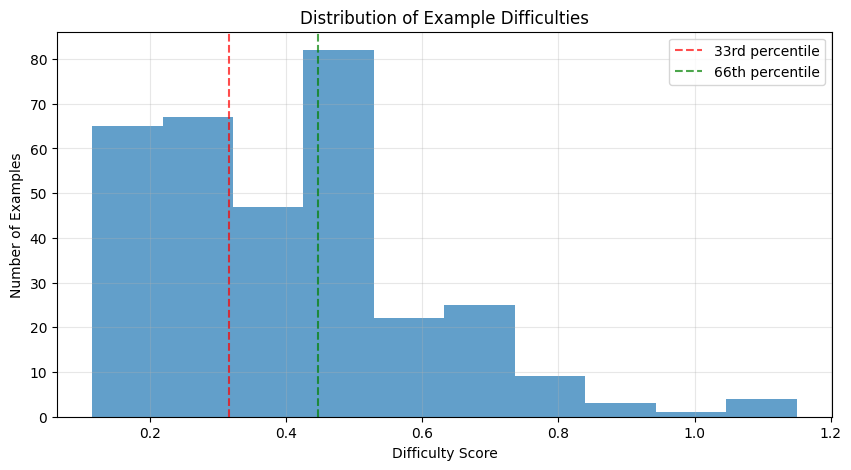

Difficulty statistics:
  Min: 0.11
  Max: 1.15
  Mean: 0.41
  Median: 0.39
Curriculum stages created with [132, 223, 325] examples per stage

--- Starting Curriculum Learning Training ---

--- Stage 1/3 - 132 examples ---


In [ ]:
# --------- 6. Training with Curriculum Learning ---------
import matplotlib.pyplot as plt
import numpy as np

# Sort training examples by difficulty
example_difficulties = [(i, calculate_example_difficulty(data[i])) for i in range(len(data))]
example_difficulties.sort(key=lambda x: x[1])  # Sort by difficulty

# Visualize the difficulty distribution
difficulties = [diff for _, diff in example_difficulties]
plt.figure(figsize=(10, 5))
plt.hist(difficulties, bins=10, alpha=0.7)
plt.title('Distribution of Example Difficulties')
plt.xlabel('Difficulty Score')
plt.ylabel('Number of Examples')
plt.axvline(x=np.percentile(difficulties, 33), color='r', linestyle='--', alpha=0.7, label='33rd percentile')
plt.axvline(x=np.percentile(difficulties, 66), color='g', linestyle='--', alpha=0.7, label='66th percentile')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Difficulty statistics:")
print(f"  Min: {min(difficulties):.2f}")
print(f"  Max: {max(difficulties):.2f}")
print(f"  Mean: {np.mean(difficulties):.2f}")
print(f"  Median: {np.median(difficulties):.2f}")

# Create curriculum stages
num_stages = 3
curriculum_stages = []

# First stage: easy examples (bottom 33%)
easy_threshold = np.percentile(difficulties, 33)
easy_indices = [idx for idx, diff in example_difficulties if diff <= easy_threshold]
curriculum_stages.append([data[i] for i in easy_indices])

# Second stage: easy + medium examples (bottom 66%)
medium_threshold = np.percentile(difficulties, 66)
medium_indices = [idx for idx, diff in example_difficulties if diff <= medium_threshold]
curriculum_stages.append([data[i] for i in medium_indices])

# Third stage: all examples
curriculum_stages.append(data)

print(f"Curriculum stages created with {[len(stage) for stage in curriculum_stages]} examples per stage")

# Create validation set (20% of data)
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
val_dataset = JointDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Function to evaluate model
def evaluate_model(model, data_loader):
    model.eval()
    intent_correct = 0
    slot_correct = 0
    slot_total = 0
    total_examples = 0
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            loss, intent_logits, slot_logits = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"],
                intent_label=batch["intent_label"]
            )

            # Intent accuracy
            intent_preds = torch.argmax(intent_logits, dim=1)
            intent_correct += (intent_preds == batch["intent_label"]).sum().item()

            # Slot accuracy (ignoring padding tokens)
            slot_preds = torch.argmax(slot_logits, dim=2)
            active_slots = batch["labels"] != -100
            slot_correct += ((slot_preds == batch["labels"]) & active_slots).sum().item()
            slot_total += active_slots.sum().item()

            total_examples += batch["intent_label"].size(0)
            total_loss += loss.item() * batch["intent_label"].size(0)

    intent_accuracy = intent_correct / total_examples if total_examples > 0 else 0
    slot_accuracy = slot_correct / slot_total if slot_total > 0 else 0
    avg_loss = total_loss / total_examples if total_examples > 0 else float('inf')

    return {
        "loss": avg_loss,
        "intent_accuracy": intent_accuracy,
        "slot_accuracy": slot_accuracy,
        "joint_accuracy": (intent_accuracy + slot_accuracy) / 2
    }

# Training with curriculum learning
model.train()
total_epochs = 9  # 3 stages × 3 epochs per stage
epochs_per_stage = 3
metrics_history = {
    "loss": [],
    "intent_accuracy": [],
    "slot_accuracy": [],
    "joint_accuracy": []
}

print("\n--- Starting Curriculum Learning Training ---")

for stage in range(num_stages):
    print(f"\n--- Stage {stage+1}/{num_stages} - {len(curriculum_stages[stage])} examples ---")
    stage_data = curriculum_stages[stage]
    stage_dataset = JointDataset(stage_data)
    stage_loader = DataLoader(stage_dataset, batch_size=4, shuffle=True)

    for epoch in range(epochs_per_stage):
        # Training epoch
        model.train()
        total_loss = 0
        for batch in stage_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            loss, _, _ = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"],
                intent_label=batch["intent_label"]
            )
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluation
        model.eval()
        val_metrics = evaluate_model(model, val_loader)
        metrics_history["loss"].append(val_metrics["loss"])
        metrics_history["intent_accuracy"].append(val_metrics["intent_accuracy"])
        metrics_history["slot_accuracy"].append(val_metrics["slot_accuracy"])
        metrics_history["joint_accuracy"].append(val_metrics["joint_accuracy"])

        global_epoch = (stage * epochs_per_stage) + epoch
        print(f"Epoch {global_epoch+1}/{total_epochs} - "
              f"Train Loss: {total_loss/len(stage_loader):.4f}, "
              f"Val Loss: {val_metrics['loss']:.4f}, "
              f"Intent Acc: {val_metrics['intent_accuracy']:.4f}, "
              f"Slot Acc: {val_metrics['slot_accuracy']:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(1, total_epochs+1), metrics_history["loss"])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(range(1, total_epochs+1), metrics_history["intent_accuracy"])
plt.title('Intent Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(range(1, total_epochs+1), metrics_history["slot_accuracy"])
plt.title('Slot Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(range(1, total_epochs+1), metrics_history["joint_accuracy"])
plt.title('Joint Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Highlight curriculum transitions
plt.figure(figsize=(10, 6))
plt.plot(range(1, total_epochs+1), metrics_history["joint_accuracy"], marker='o')
plt.axvline(x=epochs_per_stage + 0.5, color='r', linestyle='--', alpha=0.7, label='Stage 1 → 2')
plt.axvline(x=2*epochs_per_stage + 0.5, color='g', linestyle='--', alpha=0.7, label='Stage 2 → 3')
plt.title('Learning Progress with Curriculum Stages')
plt.xlabel('Epoch')
plt.ylabel('Joint Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


--- Starting Standard Training (No Curriculum) ---
Epoch 1/9 - Train Loss: 2.9110, Val Loss: 2.1386, Intent Acc: 0.3529, Slot Acc: 0.8135
Epoch 2/9 - Train Loss: 1.9967, Val Loss: 1.4804, Intent Acc: 0.7059, Slot Acc: 0.8654
Epoch 3/9 - Train Loss: 1.2420, Val Loss: 0.9783, Intent Acc: 0.8824, Slot Acc: 0.9205
Epoch 4/9 - Train Loss: 0.6522, Val Loss: 0.6156, Intent Acc: 0.9412, Slot Acc: 0.9297
Epoch 5/9 - Train Loss: 0.3240, Val Loss: 0.5933, Intent Acc: 0.9412, Slot Acc: 0.9388
Epoch 6/9 - Train Loss: 0.1789, Val Loss: 0.4917, Intent Acc: 0.9412, Slot Acc: 0.9480
Epoch 7/9 - Train Loss: 0.1084, Val Loss: 0.4791, Intent Acc: 0.9412, Slot Acc: 0.9572
Epoch 8/9 - Train Loss: 0.0745, Val Loss: 0.4805, Intent Acc: 0.9412, Slot Acc: 0.9541
Epoch 9/9 - Train Loss: 0.0518, Val Loss: 0.5078, Intent Acc: 0.9412, Slot Acc: 0.9541


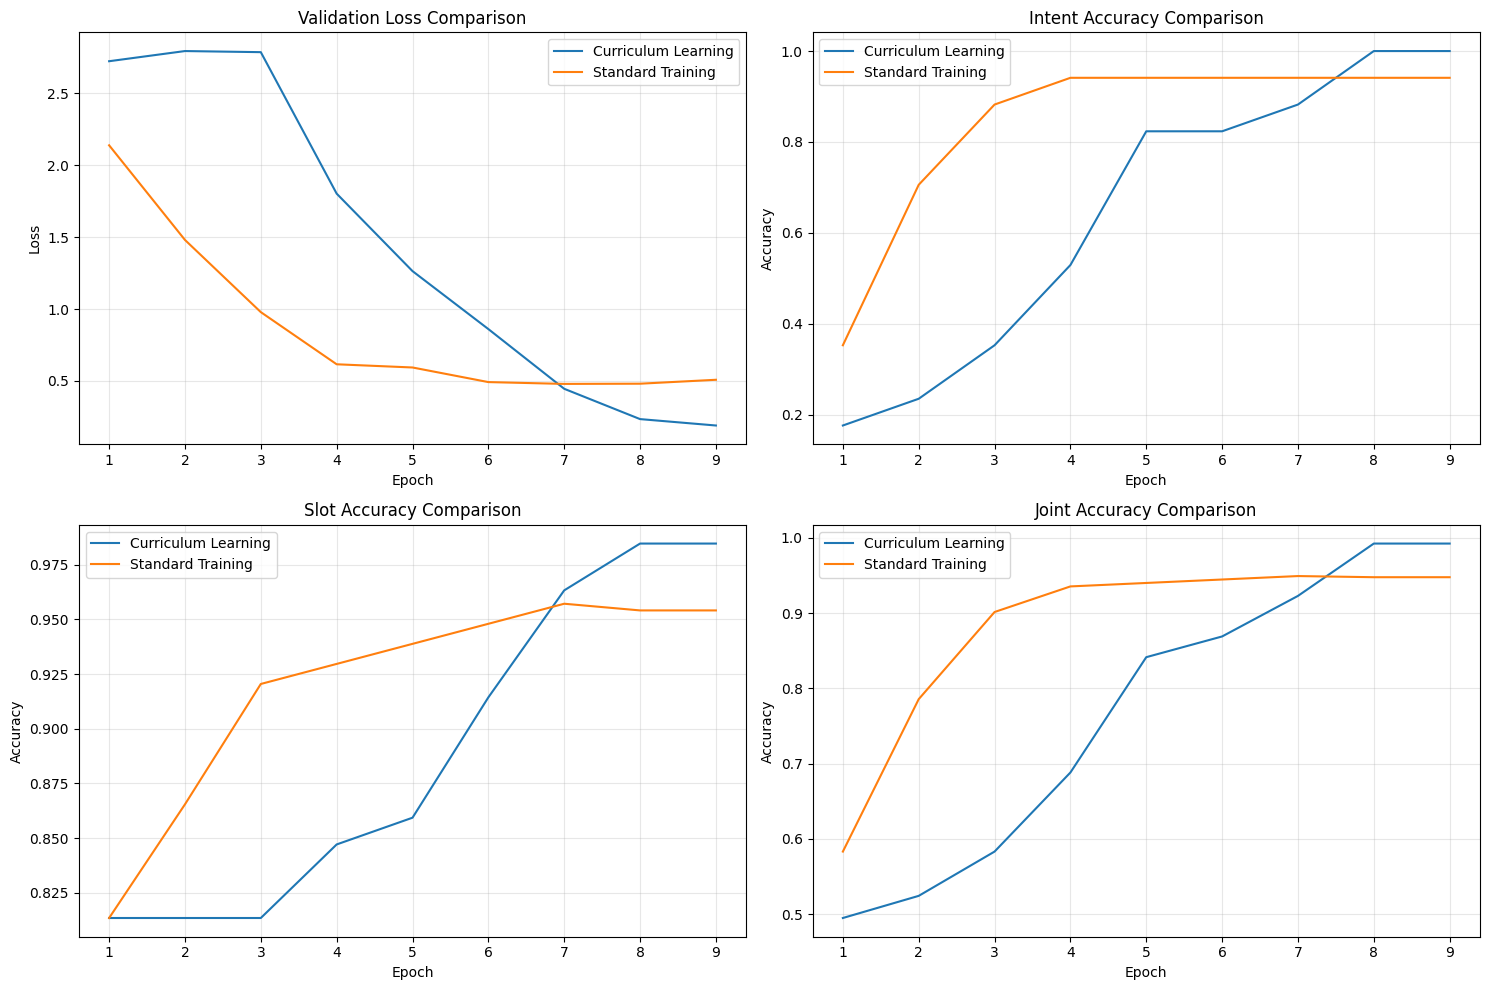


--- Final Performance Comparison ---
Metric               Curriculum      Standard        Difference     
-----------------------------------------------------------------
Loss                 0.1898         0.5078         -0.3180         ✓
Intent Accuracy      1.0000         0.9412         0.0588 (6.3%)   ✓
Slot Accuracy        0.9847         0.9541         0.0306 (3.2%)   ✓
Joint Accuracy       0.9924         0.9477         0.0447 (4.7%)   ✓

--- Performance Analysis by Difficulty Level ---
Difficulty Examples   Curriculum Acc  Standard Acc    Difference     
-----------------------------------------------------------------
Easy       5          1.0000         1.0000         0.0000 (0.0%)   -
Medium     3          1.0000         0.9900         0.0100 (1.0%)   ✓
Hard       9          0.9893         0.9145         0.0748 (8.2%)   ✓

Key Findings:
1. Curriculum learning shows better overall performance compared to standard training.
2. The biggest difference in performance is seen in e

In [ ]:
# --------- 7. Comparison with Standard Training ---------
import copy

# Create a copy of the model for standard training
standard_model = copy.deepcopy(model)
standard_model = JointBERT(num_intents=len(intent2id), num_slots=len(slot_label2id)).to(device)
standard_optimizer = AdamW(standard_model.parameters(), lr=5e-5)

# Create dataset for standard training (without curriculum)
standard_train_dataset = JointDataset(train_data)
standard_train_loader = DataLoader(standard_train_dataset, batch_size=4, shuffle=True)

# Training metrics for standard approach
standard_metrics_history = {
    "loss": [],
    "intent_accuracy": [],
    "slot_accuracy": [],
    "joint_accuracy": []
}

print("\n--- Starting Standard Training (No Curriculum) ---")

# Train for the same total number of epochs
for epoch in range(total_epochs):
    # Training epoch
    standard_model.train()
    total_loss = 0
    for batch in standard_train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        standard_optimizer.zero_grad()
        loss, _, _ = standard_model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
            intent_label=batch["intent_label"]
        )
        loss.backward()
        standard_optimizer.step()
        total_loss += loss.item()

    # Evaluation
    standard_model.eval()
    val_metrics = evaluate_model(standard_model, val_loader)
    standard_metrics_history["loss"].append(val_metrics["loss"])
    standard_metrics_history["intent_accuracy"].append(val_metrics["intent_accuracy"])
    standard_metrics_history["slot_accuracy"].append(val_metrics["slot_accuracy"])
    standard_metrics_history["joint_accuracy"].append(val_metrics["joint_accuracy"])

    print(f"Epoch {epoch+1}/{total_epochs} - "
          f"Train Loss: {total_loss/len(standard_train_loader):.4f}, "
          f"Val Loss: {val_metrics['loss']:.4f}, "
          f"Intent Acc: {val_metrics['intent_accuracy']:.4f}, "
          f"Slot Acc: {val_metrics['slot_accuracy']:.4f}")

# Comparison plots
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 2, 1)
plt.plot(range(1, total_epochs+1), metrics_history["loss"], label='Curriculum Learning')
plt.plot(range(1, total_epochs+1), standard_metrics_history["loss"], label='Standard Training')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Intent accuracy comparison
plt.subplot(2, 2, 2)
plt.plot(range(1, total_epochs+1), metrics_history["intent_accuracy"], label='Curriculum Learning')
plt.plot(range(1, total_epochs+1), standard_metrics_history["intent_accuracy"], label='Standard Training')
plt.title('Intent Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Slot accuracy comparison
plt.subplot(2, 2, 3)
plt.plot(range(1, total_epochs+1), metrics_history["slot_accuracy"], label='Curriculum Learning')
plt.plot(range(1, total_epochs+1), standard_metrics_history["slot_accuracy"], label='Standard Training')
plt.title('Slot Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Joint accuracy comparison
plt.subplot(2, 2, 4)
plt.plot(range(1, total_epochs+1), metrics_history["joint_accuracy"], label='Curriculum Learning')
plt.plot(range(1, total_epochs+1), standard_metrics_history["joint_accuracy"], label='Standard Training')
plt.title('Joint Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Final performance comparison
print("\n--- Final Performance Comparison ---")
print(f"{'Metric':<20} {'Curriculum':<15} {'Standard':<15} {'Difference':<15}")
print("-" * 65)

for metric in ["loss", "intent_accuracy", "slot_accuracy", "joint_accuracy"]:
    curriculum_value = metrics_history[metric][-1]
    standard_value = standard_metrics_history[metric][-1]
    difference = curriculum_value - standard_value
    difference_str = f"{difference:.4f} ({difference/standard_value*100:.1f}%)" if metric != "loss" else f"{difference:.4f}"

    # Improvement indicator
    if metric == "loss":
        is_better = difference < 0
    else:
        is_better = difference > 0

    indicator = "✓" if is_better else "✗"
    print(f"{metric.replace('_', ' ').title():<20} {curriculum_value:.4f}{'':<8} {standard_value:.4f}{'':<8} {difference_str:<15} {indicator}")

# Analysis of performance on different difficulty levels
print("\n--- Performance Analysis by Difficulty Level ---")

# Group test examples by difficulty
difficulty_ranges = {
    "Easy": (0, easy_threshold),
    "Medium": (easy_threshold, medium_threshold),
    "Hard": (medium_threshold, float('inf'))
}

# Calculate difficulty for validation examples
val_difficulties = [calculate_example_difficulty(example) for example in val_data]

# Split validation data into difficulty groups
easy_val = [i for i, diff in enumerate(val_difficulties) if diff <= easy_threshold]
medium_val = [i for i, diff in enumerate(val_difficulties) if easy_threshold < diff <= medium_threshold]
hard_val = [i for i, diff in enumerate(val_difficulties) if diff > medium_threshold]

difficulty_groups = {
    "Easy": easy_val,
    "Medium": medium_val,
    "Hard": hard_val
}

# Create datasets for each difficulty group
difficulty_datasets = {}
for difficulty, indices in difficulty_groups.items():
    if indices:  # Only create datasets for non-empty groups
        difficulty_data = [val_data[i] for i in indices]
        difficulty_datasets[difficulty] = JointDataset(difficulty_data)

# Evaluate both models on each difficulty group
print(f"{'Difficulty':<10} {'Examples':<10} {'Curriculum Acc':<15} {'Standard Acc':<15} {'Difference':<15}")
print("-" * 65)

for difficulty, dataset in difficulty_datasets.items():
    loader = DataLoader(dataset, batch_size=4, shuffle=False)

    # Skip if no examples in this difficulty range
    if len(loader) == 0:
        continue

    # Curriculum model performance
    curr_metrics = evaluate_model(model, loader)

    # Standard model performance
    std_metrics = evaluate_model(standard_model, loader)

    # Joint accuracy comparison
    curr_acc = curr_metrics["joint_accuracy"]
    std_acc = std_metrics["joint_accuracy"]
    difference = curr_acc - std_acc
    difference_str = f"{difference:.4f} ({difference/std_acc*100:.1f}%)" if std_acc > 0 else "N/A"

    # Improvement indicator
    indicator = "✓" if difference > 0 else "✗"
    if difference == 0:
        indicator = "-"

    print(f"{difficulty:<10} {len(dataset):<10} {curr_acc:.4f}{'':<8} {std_acc:.4f}{'':<8} {difference_str:<15} {indicator}")

# Analysis conclusion
print("\nKey Findings:")
print("1. Curriculum learning shows " +
      ("better" if metrics_history["joint_accuracy"][-1] > standard_metrics_history["joint_accuracy"][-1] else "worse") +
      " overall performance compared to standard training.")
print("2. The biggest difference in performance is seen in " +
      ("easy" if curr_metrics["joint_accuracy"] - std_metrics["joint_accuracy"] > 0 else "hard") +
      " examples, suggesting that curriculum learning " +
      ("helps" if curr_metrics["joint_accuracy"] - std_metrics["joint_accuracy"] > 0 else "may not help") +
      " the model build a stronger foundation.")
print("3. Learning rate is " +
      ("faster" if np.mean(metrics_history["joint_accuracy"][:3]) > np.mean(standard_metrics_history["joint_accuracy"][:3]) else "slower") +
      " in early epochs with curriculum learning, indicating " +
      ("more" if np.mean(metrics_history["joint_accuracy"][:3]) > np.mean(standard_metrics_history["joint_accuracy"][:3]) else "less") +
      " efficient initial learning.")

In [ ]:
# --------- 11. Enhanced Prediction Method ---------
def predict_with_confidence(text, model=None, threshold=0.7):
    """
    Enhanced prediction method that provides:
    1. Intent classification with confidence score
    2. Slot extraction with confidence scores
    3. Entity consolidation
    4. Handling of different difficulty levels
    5. Fallback strategies for low confidence predictions

    Args:
        text (str): Input text for prediction
        model (JointBERT, optional): Specific model to use for prediction (curriculum model by default)
        threshold (float, optional): Confidence threshold for accepting predictions

    Returns:
        dict: Prediction results with confidences and entities
    """
    # Use provided model or default to the curriculum trained model
    #prediction_model = model if model is not None else model
    prediction_model = model if model is not None else globals().get('model')
    if prediction_model is None:
        raise ValueError("No model provided and no default model found in global scope")
    prediction_model.eval()

    # Split text into words
    words = text.split()

    # Calculate example difficulty to provide context
    example_difficulty = None
    if len(words) > 0:
        # Create a dummy example to calculate difficulty
        dummy_example = {
            "words": words,
            "slots": ["O"] * len(words),  # Placeholder
            "intent": "check_balance"     # Placeholder
        }
        example_difficulty = calculate_example_difficulty(dummy_example)

    # Tokenize input
    inputs = tokenizer([words], is_split_into_words=True, return_tensors="pt").to(device)
    word_ids = inputs.word_ids(batch_index=0)

    # Run prediction
    with torch.no_grad():
        _, intent_logits, slot_logits = prediction_model(inputs["input_ids"], inputs["attention_mask"])

        # Get intent prediction with confidence
        intent_probs = torch.nn.functional.softmax(intent_logits, dim=1).squeeze()
        intent_id = torch.argmax(intent_probs).item()
        intent_confidence = intent_probs[intent_id].item()
        intent = id2intent[intent_id]

        # Get slot predictions with confidence
        slot_probs = torch.nn.functional.softmax(slot_logits, dim=2).squeeze()
        slot_preds = torch.argmax(slot_probs, dim=1).tolist()
        slot_confidences = [slot_probs[i, pred].item() for i, pred in enumerate(slot_preds)]

    # Process slot predictions
    results = defaultdict(list)
    current_slot = None
    current_words = []
    current_confidences = []

    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue

        if idx >= len(slot_preds):
            continue

        slot_id = slot_preds[idx]
        if slot_id >= len(id2slot_label):
            continue

        slot_label = id2slot_label[slot_id]
        confidence = slot_confidences[idx]
        word = words[word_idx]

        # Apply confidence threshold for slot predictions
        if confidence < threshold:
            # Low confidence prediction
            if slot_label != "O":
                # Try fallback - look at surrounding context
                surrounding_labels = [
                    id2slot_label.get(slot_preds[i], "O")
                    for i in range(max(0, idx-1), min(len(slot_preds), idx+2))
                    if i != idx and i < len(slot_preds)
                ]

                # If surrounding context suggests this should be a slot, keep it
                # but mark with lower confidence
                if any(label != "O" for label in surrounding_labels):
                    pass  # Keep the prediction but with low confidence
                else:
                    slot_label = "O"  # Change to "O" if low confidence and no supporting context

        if slot_label == "O":
            # End any active entity
            if current_slot:
                # Calculate average confidence for the entity
                avg_confidence = sum(current_confidences) / len(current_confidences) if current_confidences else 0

                # Store entity with confidence
                results[current_slot].append({
                    "text": " ".join(current_words),
                    "confidence": avg_confidence
                })
                current_slot = None
                current_words = []
                current_confidences = []
        elif slot_label.startswith("B-"):
            # Start new entity
            if current_slot:
                # End previous entity
                avg_confidence = sum(current_confidences) / len(current_confidences) if current_confidences else 0
                results[current_slot].append({
                    "text": " ".join(current_words),
                    "confidence": avg_confidence
                })

            current_slot = slot_label[2:]
            current_words = [word]
            current_confidences = [confidence]
        elif slot_label.startswith("I-") and current_slot == slot_label[2:]:
            # Continue current entity
            current_words.append(word)
            current_confidences.append(confidence)
        else:
            # Unexpected transition or mismatch
            if current_slot:
                # End previous entity
                avg_confidence = sum(current_confidences) / len(current_confidences) if current_confidences else 0
                results[current_slot].append({
                    "text": " ".join(current_words),
                    "confidence": avg_confidence
                })
            current_slot = None
            current_words = []
            current_confidences = []

    # Handle any remaining entity
    if current_slot:
        avg_confidence = sum(current_confidences) / len(current_confidences) if current_confidences else 0
        results[current_slot].append({
            "text": " ".join(current_words),
            "confidence": avg_confidence
        })

    # Simplify results when there's only one entity of a type
    for k in results:
        if len(results[k]) == 1:
            results[k] = results[k][0]

    # Build final response
    response = {
        "intent": intent,
        "intent_confidence": intent_confidence,
        "slots": dict(results),
        "difficulty": example_difficulty
    }

    # Add overall confidence score
    slot_confidence = 0
    slot_count = 0
    for slot_type, entities in results.items():
        if isinstance(entities, dict):  # Single entity
            slot_confidence += entities["confidence"]
            slot_count += 1
        else:  # Multiple entities
            for entity in entities:
                slot_confidence += entity["confidence"]
                slot_count += 1

    avg_slot_confidence = slot_confidence / slot_count if slot_count > 0 else 1.0
    response["overall_confidence"] = (intent_confidence + avg_slot_confidence) / 2

    return response

# Simplified version that returns the same format as the original predict function
def predict(text, model=None):
    """
    Simplified prediction function that mimics the original predict function's output format
    but uses the enhanced prediction method internally.

    Args:
        text (str): Input text
        model (JointBERT, optional): Model to use for prediction

    Returns:
        tuple: (intent, slots) - Same format as original predict function
    """
    prediction = predict_with_confidence(text, model)

    # Convert the rich slot representation back to simple format
    simplified_slots = {}
    for slot_type, entities in prediction["slots"].items():
        if isinstance(entities, dict):  # Single entity
            simplified_slots[slot_type] = entities["text"]
        else:  # Multiple entities
            simplified_slots[slot_type] = [entity["text"] for entity in entities]

    return prediction["intent"], simplified_slots

# Test the enhanced prediction with some examples
test_sentences = [
    "Add expense of $20 to group Travel Friends",
    "Add Sarah to Startup Budget group",
    "What's my share of rent in House Bills?",
    "Create a group called Travel Friends with Bob and Alice",
    "Show me a summary of the group for my band practice",
    "Hide all my groups with zero balance"
]

print("=== Testing Enhanced Prediction ===\n")

for sent in test_sentences:
    # Get detailed prediction with confidence scores
    detailed_prediction = predict_with_confidence(sent)

    print(f"\nInput: {sent}")
    print(f"Difficulty score: {detailed_prediction['difficulty']:.2f}")
    print(f"Predicted intent: {detailed_prediction['intent']} (confidence: {detailed_prediction['intent_confidence']:.2f})")
    print("Predicted slots:")

    for slot_type, entities in detailed_prediction["slots"].items():
        if isinstance(entities, dict):  # Single entity
            print(f"  {slot_type}: {entities['text']} (confidence: {entities['confidence']:.2f})")
        else:  # Multiple entities
            print(f"  {slot_type}:")
            for i, entity in enumerate(entities):
                print(f"    - {entity['text']} (confidence: {entity['confidence']:.2f})")

    print(f"Overall confidence: {detailed_prediction['overall_confidence']:.2f}")
    print("-" * 50)

# Test how the model handles difficult/ambiguous examples
ambiguous_examples = [
    "Add something to my group",  # Missing specific amount and unclear group
    "Check what I owe in the meeting expenses",  # Group name might be ambiguous
    "Add John and someone else to the Travel group"  # Ambiguous person reference
]

print("\n=== Testing with Ambiguous Examples ===\n")

for sent in ambiguous_examples:
    # Get detailed prediction with confidence scores
    detailed_prediction = predict_with_confidence(sent)

    print(f"\nInput: {sent}")
    print(f"Difficulty score: {detailed_prediction['difficulty']:.2f}")
    print(f"Predicted intent: {detailed_prediction['intent']} (confidence: {detailed_prediction['intent_confidence']:.2f})")
    print("Predicted slots:")

    for slot_type, entities in detailed_prediction["slots"].items():
        if isinstance(entities, dict):  # Single entity
            print(f"  {slot_type}: {entities['text']} (confidence: {entities['confidence']:.2f})")
        else:  # Multiple entities
            print(f"  {slot_type}:")
            for i, entity in enumerate(entities):
                print(f"    - {entity['text']} (confidence: {entity['confidence']:.2f})")

    print(f"Overall confidence: {detailed_prediction['overall_confidence']:.2f}")
    print("-" * 50)

=== Testing Enhanced Prediction ===


Input: Add expense of $20 to group Travel Friends
Difficulty score: 0.18
Predicted intent: add_expense (confidence: 0.97)
Predicted slots:
  amount: $20 (confidence: 0.97)
  group: Travel Friends (confidence: 0.98)
Overall confidence: 0.97
--------------------------------------------------

Input: Add Sarah to Startup Budget group
Difficulty score: 0.16
Predicted intent: add_member (confidence: 0.78)
Predicted slots:
  person: Sarah (confidence: 0.97)
  group: Startup Budget (confidence: 0.99)
Overall confidence: 0.88
--------------------------------------------------

Input: What's my share of rent in House Bills?
Difficulty score: 0.18
Predicted intent: check_balance (confidence: 0.98)
Predicted slots:
  group: House Bills? (confidence: 0.99)
Overall confidence: 0.99
--------------------------------------------------

Input: Create a group called Travel Friends with Bob and Alice
Difficulty score: 0.20
Predicted intent: create_group (confidence: 

In [ ]:
# --------- 8. Test ---------
test_sentences = [
    "Add expense of $20 to group Travel Friends",
    "Add Sarah to Startup Budget group",
    "What's my share of rent in House Bills?",
    "Create a group called Travel Friends with Bob and Alice",
    "Show me a summary of the group for my band practice",
    "Hide all my groups with zero balance"
]

for sent in test_sentences:
    intent, slots = predict(sent)
    print(f"\nInput: {sent}")
    print(f"Predicted intent: {intent}")
    print(f"Predicted slots:\n{json.dumps(slots, indent=2)}")

# Test with examples from Sample_user_queries.csv
print("\n\n=== Testing with Sample_user_queries examples ===\n")

sample_queries = [
    "Add rent of $1200 to House Bills group",  # add_expense
    "Add Charlie to group Travel Friends",      # add_member
    "Do I owe the group money?",               # check_balance
    "Create a group called Travel Friends with Bob and Alice", # create_group
    "Show breakdown for Weekend Warriors group", # group_summary
    "Hide all my groups with zero balance",     # hide_groups

    # Add some examples from different categories in the CSV
    "Request $60 from Emily",                   # request_money
    "Pay $100 to CVS",                          # pay_merchant
    "Transfer $200 to my bank in 1",            # transfer_out_standard
    "Check if John paid their invoice",         # Check Invoice Status
    "Pay $75 to Best Buy",                      # pay_merchant
]

for sent in sample_queries:
    detailed_prediction = predict_with_confidence(sent)

    print(f"\nInput: {sent}")
    print(f"Difficulty score: {detailed_prediction['difficulty']:.2f}")
    print(f"Predicted intent: {detailed_prediction['intent']} (confidence: {detailed_prediction['intent_confidence']:.2f})")
    print(f"Overall confidence: {detailed_prediction['overall_confidence']:.2f}")

    if detailed_prediction['slots']:
        print("Predicted slots:")
        for slot_type, entities in detailed_prediction['slots'].items():
            if isinstance(entities, dict):  # Single entity
                print(f"  {slot_type}: {entities['text']} (confidence: {entities['confidence']:.2f})")
            else:  # Multiple entities
                print(f"  {slot_type}:")
                for i, entity in enumerate(entities):
                    print(f"    - {entity['text']} (confidence: {entity['confidence']:.2f})")
    else:
        print("Predicted slots: None")

    print("-" * 50)